In [1]:
%load_ext autoreload
%autoreload 2
import torch
import math
import sys
sys.path.append('/localhome/jonathan.mei/code/experiments/')

import kradagrad as kg
mf = kg.positive_matrix_functions
smf = kg.third_party.shampoo.matrix_functions

norm = lambda x: torch.abs(x).sum()

import matplotlib.pyplot as plt

In [2]:
sz = 128

sqrt_log_cond_num = math.sqrt(8)
diag = 10 ** (torch.linspace(0, sqrt_log_cond_num, sz+32) ** 2)
Ad = torch.randn(sz, sz+32, dtype=torch.float64)
Ad = (Ad*diag).mm(Ad.T).cuda()
Ad = Ad / Ad.max() + 1e-12 * torch.eye(sz, device=Ad.device)
A = Ad.float()

tensor(1.1191e-08, device='cuda:0', dtype=torch.float64) tensor(11.0990, device='cuda:0', dtype=torch.float64)


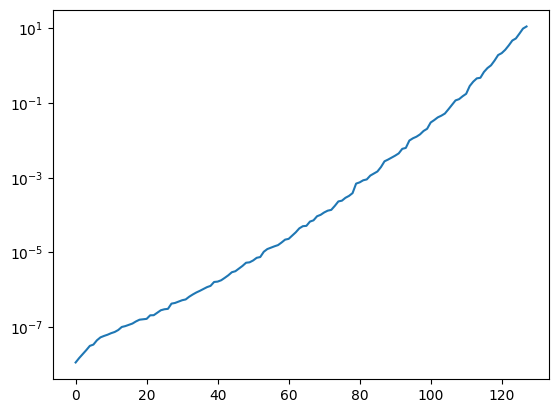

In [3]:
with torch.no_grad():
    Ld, Vd = torch.linalg.eigh(Ad)
print(Ld.min(), Ld.max())
plt.semilogy(Ld.cpu().numpy())
plt.show()

tensor(5.8911e-08, device='cuda:0') tensor(11.0993, device='cuda:0')


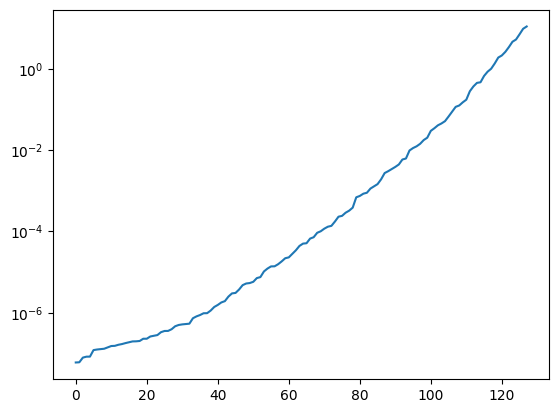

In [4]:
with torch.no_grad():
    L, V = torch.linalg.eigh(A)
print(L.min(), L.max())
plt.semilogy(L.cpu().numpy())
plt.show()

# sqrts

In [5]:
B1 = mf.matrix_power_svd(A, 0.5)
B1d = mf.matrix_power_svd(Ad, 0.5)
norm(B1 @ B1.T - A) / sz, norm(B1d @ B1d.T - A.double()) / sz, 

(tensor(0.0014, device='cuda:0'),
 tensor(0.0014, device='cuda:0', dtype=torch.float64))

In [6]:
B2 = mf.matrix_sqrt_NS(A, iters=25, norm='tr')
B2d = mf.matrix_sqrt_NS(Ad, iters=25, norm='tr', double=True)
norm(B2 @ B2.T - A) / sz, norm(B2d @ B2d.T - Ad) / sz

(tensor(0.0014, device='cuda:0'),
 tensor(9.6889e-08, device='cuda:0', dtype=torch.float64))

## inverse sqrt

In [7]:
# Invert in double to make sure it's accurate
Aid = Ad.inverse()
Ai = Aid.float()
norm(Ai @ A - torch.eye(sz, device=A.device)) / sz, norm(Aid @ Ad - torch.eye(sz, device=Ad.device)) / sz


(tensor(16.7318, device='cuda:0'),
 tensor(4.1128e-07, device='cuda:0', dtype=torch.float64))

In [29]:
Aii = mf.matrix_power_svd(Ai, -1, eps=1e-12)
Aiid = mf.matrix_power_svd(Aid, -1, double=True, eps=1e-12)
norm(Ai - A) / sz, norm(Aiid - Ad) / sz

(tensor(1.0991e+08, device='cuda:0'),
 tensor(14.2084, device='cuda:0', dtype=torch.float64))

In [8]:
# compute -1/2 power of Ai using shampoo libs
B3 = smf.ComputePower(Ai, 2)
B3d = smf.ComputePower(Aid, 2, double=True)
norm(B3 @ B3.T - A) / sz, norm(B3d @ B3d.T - Ad) / sz

(tensor(14.1968, device='cuda:0'),
 tensor(14.1968, device='cuda:0', dtype=torch.float64))

In [32]:
# compute -1/2 power of A using shampoo libs
B3i = smf.ComputePower(A, 2)
B3id = smf.ComputePower(Ad, 2, double=True)
norm(B3i @ A @ B3i.T - torch.eye(sz, device=A.device)) / sz, norm(B3id @ Ad @ B3id.T - torch.eye(sz, device=Ad.device)) / sz

(tensor(0.0709, device='cuda:0'),
 tensor(2.4401e-07, device='cuda:0', dtype=torch.float64))

In [33]:
# compute -1/2 power of Ai using eigh
Bii = mf.matrix_power_svd(Ai, -0.5, eps=1e-12)
Biid = mf.matrix_power_svd(Aid, -0.5, double=True, eps=1e-12)
norm(Bii @ Bii.T - A) / sz, norm(Biid @ Biid.T - Ad) / sz

(tensor(14.2085, device='cuda:0'),
 tensor(14.2084, device='cuda:0', dtype=torch.float64))

In [38]:
# compute -1/2 power of A using eigh
Bi = mf.matrix_power_svd(A, -0.5, eps=1e-12)
Bid = mf.matrix_power_svd(Ad, -0.5, double=True, eps=1e-12)
print(norm(Bi @ A @ Bi.T - torch.eye(sz, device=A.device)) / sz, norm(Bid @ Ad @ Bid.T - torch.eye(sz, device=Ad.device)) / sz)

norm(Bi @ Bi.T - Ai) / sz, norm(Bid @ Bid.T - Aid) / sz


tensor(0.1165, device='cuda:0') tensor(1.3384e-07, device='cuda:0', dtype=torch.float64)


(tensor(1.0985e+08, device='cuda:0'),
 tensor(1.0985e+08, device='cuda:0', dtype=torch.float64))

 # inverse 4th root (as in shampoo)

In [27]:
# compute -1/4 power of Ai using shampoo libs
Bii2 = smf.ComputePower(Ai, 4)
Bii2d = smf.ComputePower(Aid, 4, double=True)
norm(mf.mat_pow(Bii2, 4) - A) / sz, norm(mf.mat_pow(Bii2d, 4) - Ad) / sz

(tensor(14.2084, device='cuda:0'),
 tensor(14.2084, device='cuda:0', dtype=torch.float64))

In [39]:
# compute -1/4 power of Ai using shampoo libs
Bi2 = smf.ComputePower(A, 4)
Bi2d = smf.ComputePower(Ad, 4, double=True)
print(norm(mf.mat_pow(Bi2, 4) @ A - torch.eye(sz, device=A.device)) / sz, norm(mf.mat_pow(Bi2d, 4) @ Ad - torch.eye(sz, device=Ad.device)) / sz)
norm(mf.mat_pow(Bi2, 4) - Ai) / sz, norm(mf.mat_pow(Bi2d, 4) - Aid) / sz


tensor(0.0846, device='cuda:0') tensor(2.0144e-06, device='cuda:0', dtype=torch.float64)


(tensor(1.0986e+08, device='cuda:0'),
 tensor(1.0986e+08, device='cuda:0', dtype=torch.float64))

In [35]:
# compute -1/4 power of Ai using eigh
Bii3 = mf.matrix_power_svd(Ai, -0.25, eps=1e-12)
Bii3d = mf.matrix_power_svd(Aid, -0.25, double=True, eps=1e-12)
norm(mf.mat_pow(Bii3, 4) - A) / sz, norm(mf.mat_pow(Bii3d, 4) - Ad) / sz

(tensor(14.2085, device='cuda:0'),
 tensor(14.2084, device='cuda:0', dtype=torch.float64))

# 4th roots

In [10]:
B4 = mf.mat_root(A, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-6, norm='tr')
B4d = mf.mat_root(Ad, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-4, norm='tr', double=True)

norm(mf.mat_pow(B4, 4) - A) / sz, norm(mf.mat_pow(B4d, 4) - Ad) / sz

(tensor(0.0001, device='cuda:0'),
 tensor(4.5424e-05, device='cuda:0', dtype=torch.float64))

In [11]:
B5 = mf.matrix_power_svd(A, 0.25)
B5d = mf.matrix_power_svd(Ad, 0.25, double=True)
norm(mf.mat_pow(B5, 4) - A) / sz, norm(mf.mat_pow(B4d, 4) - Ad) / sz

(tensor(0.0023, device='cuda:0'),
 tensor(4.5424e-05, device='cuda:0', dtype=torch.float64))

In [12]:
B6 = mf.matrix_sqrt_NS(B2, iters=25, norm='tr')
B6d = mf.matrix_sqrt_NS(B2d, iters=25, norm='tr', double=True)

norm(mf.mat_pow(B6, 4) - A) / sz, norm(mf.mat_pow(B6d, 4) - Ad) / sz

(tensor(inf, device='cuda:0'),
 tensor(9.6889e-08, device='cuda:0', dtype=torch.float64))

# 6th root

In [14]:
B7 = mf.matrix_power_svd(A, 1/6)
B7d = mf.matrix_power_svd(Ad, 1/6, double=True)
norm(mf.mat_pow(B7, 6) - A) / sz, norm(mf.mat_pow(B7d, 6) - Ad) / sz

(tensor(0.0032, device='cuda:0'),
 tensor(7.4948e-14, device='cuda:0', dtype=torch.float64))

In [15]:
B8 = mf.matrix_sqrt_NS(mf.matrix_power_svd(A, 1/3), iters=25, norm='tr')
B8d = mf.matrix_sqrt_NS(mf.matrix_power_svd(Ad, 1/3), iters=25, norm='tr', double=True)
norm(mf.mat_pow(B8, 6) - A) / sz, norm(mf.mat_pow(B8d, 6) - Ad) / sz

(tensor(0.0019, device='cuda:0'),
 tensor(0.0018, device='cuda:0', dtype=torch.float64))

In [16]:
B9 = mf.matrix_power_svd(mf.matrix_sqrt_NS(A, iters=25, norm='tr'), 1/3)
B9d = mf.matrix_power_svd(mf.matrix_sqrt_NS(A, iters=25, norm='tr', double=True), 1/3)
norm(mf.mat_pow(B9, 6) - A) / sz, norm(mf.mat_pow(B9d, 6) - Ad) / sz

(tensor(0.0053, device='cuda:0'),
 tensor(0.0043, device='cuda:0', dtype=torch.float64))

# Timing

In [21]:
%%timeit

torch.cuda.synchronize()
mf.matrix_sqrt_NS(mf.matrix_sqrt_NS(A))
torch.cuda.synchronize()

10 ms ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit

torch.cuda.synchronize()
mf.matrix_sqrt_NS(mf.matrix_sqrt_NS(Ad, double=True), double=True)
torch.cuda.synchronize()

11.1 ms ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(A, 4)
torch.cuda.synchronize()

3.29 ms ± 716 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(Ad, 4, double=True)
torch.cuda.synchronize()

5.64 ms ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%%timeit

torch.cuda.synchronize()
mf.mat_root(A, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-6, norm='tr')
torch.cuda.synchronize()

29.3 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit

torch.cuda.synchronize()
mf.mat_root(Ad, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-6, norm='tr', double=True)
torch.cuda.synchronize()

32.9 ms ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
import time
def timer(fun, A, n):
    st = time.time()
    torch.cuda.synchronize()
    for _ in range(n):
        fun(A)
    torch.cuda.synchronize()
    print(time.time()-st)

n = 100

ns2 = lambda a: mf.matrix_sqrt_NS(mf.matrix_sqrt_NS(a))
ns2d = lambda ad: mf.matrix_sqrt_NS(mf.matrix_sqrt_NS(ad, double=True), double=True)
timer(ns2, A, n)
timer(ns2d, Ad, n)

mpsvd = lambda a: mf.matrix_power_svd(a, 4)
mpsvdd = lambda ad: mf.matrix_power_svd(ad, 4, double=True)
timer(mpsvd, A, n)
timer(mpsvdd, Ad, n)

mr = lambda a: mf.mat_root(a, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-6, norm='tr')
mrd = lambda ad: mf.mat_root(ad, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-6, norm='tr', double=True)
timer(mr, A, n)
timer(mrd, Ad, n)

1.001305341720581
1.1095681190490723
0.3265082836151123
0.5595057010650635
2.915877342224121
3.2717089653015137


^ consistent